# Mineração de Dados / Statistical Machine Learning
    Lista 1
    Rafael Izbicki

# Importando as bibliotecas

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.size'] = '13'

import warnings; warnings.simplefilter('ignore')

# Lista 01 
**Exercı́cio 1**
* Considere o banco <a href="https://www.dropbox.com/s/8auhk2zaogovjvn/houses_to_rent_v2.csv?dl=0">houses_to_rent_v2</a>, que contém o valor (em reais) do aluguel de imóveis no Brasil. Você pode trabalhar apenas com os imóveis localizados em São Paulo, Rio de Janeiro e Belo Horizonte.
1. Divida o conjunto de dados em para treinamento e teste. Explique como decidiu qual porcentagem deixar
para cada um.
2. Utilizando o conjunto de treinamento, ajuste uma regressão (i) via mı́nimos quadrados, (ii) via lasso (usando validação-cruzada no treinamento para escolher λ) e (iii) (Pós-graduação apenas) regressão ridge. Qual o melhor valor de λ encontrado para o lasso?
3. Qual dos métodos acima apresentou melhores resultados? Responda essa pergunta utilizando o conjunto de teste e o melhor valor de λ encontrado. Inclua os intervalos de confiança para o risco preditivo nos seus resultados.
4. Interprete os resultados do melhor modelo encontrado (via coeficientes). Ele faz sentido?
5. Includa todas as interações entre as variáveis observadas e repita o ajuste do método de mı́nimos quadrados e o lasso. Como esses ajustes se comparam em relação aos anteriores? Qual foi o melhor modelo encontrado?Esses resultados são esperados?

## Importando os dados para "df"

In [2]:
df = pd.read_csv('houses_to_rent_v2.csv')

In [3]:
df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,rent amount (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,3300
1,São Paulo,320,4,4,0,20,acept,not furnished,4960
2,Porto Alegre,80,1,1,1,6,acept,not furnished,2800
3,Porto Alegre,51,2,1,0,2,acept,not furnished,1112
4,São Paulo,25,1,1,0,1,not acept,not furnished,800
...,...,...,...,...,...,...,...,...,...
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,1478
10688,São Paulo,285,4,4,4,17,acept,not furnished,15000
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,6000
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,12000


## Seleciando apenas as cidades de São Paulo / Rio de Janeiro / Belo Horizonte

In [4]:
df=df.loc[df['city'].isin(['São Paulo', 'Rio de Janeiro','Belo Horizonte'])]

In [5]:
df['city'].unique()

array(['São Paulo', 'Rio de Janeiro', 'Belo Horizonte'], dtype=object)

## Verificando Valores Faltantes

In [6]:
df.isnull().sum()

city                0
area                0
rooms               0
bathroom            0
parking spaces      0
floor               0
animal              0
furniture           0
rent amount (R$)    0
dtype: int64

## valores categóricos

In [7]:
df.select_dtypes(include='object')

,city,floor,animal,furniture
0,São Paulo,7,acept,furnished
1,São Paulo,20,acept,not furnished
4,São Paulo,1,not acept,not furnished
5,São Paulo,-,acept,not furnished
6,Rio de Janeiro,7,acept,not furnished
...,...,...,...,...
10686,São Paulo,8,not acept,furnished
10688,São Paulo,17,acept,not furnished
10689,Rio de Janeiro,8,not acept,furnished
10690,Rio de Janeiro,8,acept,furnished


## Foi verificado que a variável "floor" é uma variável numérica e está como uma variável categórica

In [8]:
df['floor'].unique()

array(['7', '20', '1', '-', '4', '3', '2', '11', '24', '9', '8', '17',
       '18', '10', '5', '6', '13', '15', '16', '14', '26', '12', '21',
       '19', '22', '27', '23', '35', '25', '46', '28', '29', '301', '32'],
      dtype=object)

### Foi encontrado um Valor com resultado igual "-" , substituirei por "0", tendo em vista que "-" representa os imóveis do tipo casa
### Também foi encontrado o valor "301" , foi subistituido por "31" (erro de digitação)

In [9]:
df['floor']=df['floor'].replace('-',0)

In [10]:
df['floor']=df['floor'].replace('301',31)

### Transformando a variável "floor" em (int) númerica

In [11]:
df['floor']=df['floor'].astype(int)

In [12]:
df['floor'].unique()

array([ 7, 20,  1,  0,  4,  3,  2, 11, 24,  9,  8, 17, 18, 10,  5,  6, 13,
       15, 16, 14, 26, 12, 21, 19, 22, 27, 23, 35, 25, 46, 28, 29, 31, 32])

## Area

In [13]:
df.describe()

,area,rooms,bathroom,parking spaces,floor,rent amount (R$)
count,8646.000000,8646.000000,8646.000000,8646.000000,8646.000000,8646.000000
mean,156.661115,2.571362,2.334606,1.692112,5.273074,4263.145848
std,578.798453,1.184509,1.438904,1.631614,5.566926,3531.918246
min,11.000000,1.000000,1.000000,0.000000,0.000000,450.000000
25%,60.000000,2.000000,1.000000,1.000000,1.000000,1751.500000
50%,100.000000,3.000000,2.000000,1.000000,4.000000,3000.000000
75%,200.000000,3.000000,3.000000,2.000000,8.000000,5500.000000
max,46335.000000,13.000000,10.000000,12.000000,46.000000,45000.000000


In [14]:
df[df['area']>1000]

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,rent amount (R$)
654,São Paulo,1600,6,6,6,0,acept,furnished,7600
2397,Belo Horizonte,46335,4,8,5,11,acept,furnished,8500
2423,Belo Horizonte,1020,5,4,6,0,acept,furnished,6520
3559,São Paulo,1100,4,6,10,0,acept,not furnished,14000
4813,São Paulo,1600,4,5,12,0,acept,not furnished,6900
5129,Belo Horizonte,2000,4,2,3,0,acept,not furnished,4956
5915,São Paulo,24606,5,4,4,12,acept,not furnished,8100
8790,Belo Horizonte,2000,3,3,2,2,acept,furnished,5000


### Os imóveis 2397, 5915 e 8790 aprensetam a area incompatível com a area de um Prédio.

In [15]:
df.drop([2397, 5915 ,8790],axis=0,inplace=True)

## Verificando variável categórica

In [16]:
df.select_dtypes(include='object')

,city,animal,furniture
0,São Paulo,acept,furnished
1,São Paulo,acept,not furnished
4,São Paulo,not acept,not furnished
5,São Paulo,acept,not furnished
6,Rio de Janeiro,acept,not furnished
...,...,...,...
10686,São Paulo,not acept,furnished
10688,São Paulo,acept,not furnished
10689,Rio de Janeiro,not acept,furnished
10690,Rio de Janeiro,acept,furnished


In [17]:
df['animal'].unique()

array(['acept', 'not acept'], dtype=object)

In [18]:
df['furniture'].unique()

array(['furnished', 'not furnished'], dtype=object)

## Verificando variável númerica 

In [19]:
df.select_dtypes(exclude='object')

,area,rooms,bathroom,parking spaces,floor,rent amount (R$)
0,70,2,1,1,7,3300
1,320,4,4,0,20,4960
4,25,1,1,0,1,800
5,376,3,3,7,0,8000
6,72,2,1,0,7,8000
...,...,...,...,...,...,...
10686,150,3,3,2,8,13500
10688,285,4,4,4,17,15000
10689,70,3,3,0,8,6000
10690,120,2,2,2,8,12000


In [20]:
df['rooms'].unique()

array([ 2,  4,  1,  3,  7,  5,  8,  6, 10, 13,  9])

In [21]:
df['bathroom'].unique()

array([ 1,  4,  3,  2,  5,  6,  9,  7, 10,  8])

In [22]:
df['area'].describe()

count    8643.000000
mean      148.276177
std       136.883694
min        11.000000
25%        60.000000
50%       100.000000
75%       200.000000
max      2000.000000
Name: area, dtype: float64

## Verificando variável alvo - 'rent amount (R$)'

(array([1.98132351e-04, 1.78420403e-04, 9.84039165e-05, 5.68763730e-05,
        3.77877272e-05, 3.44374751e-05, 1.95561228e-05, 1.73745632e-05,
        9.42745360e-06, 2.20493336e-05, 7.79128397e-08, 7.79128397e-08,
        7.79128397e-08, 3.89564198e-07, 0.00000000e+00, 7.79128397e-08,
        7.79128397e-08, 0.00000000e+00, 0.00000000e+00, 7.79128397e-08,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.79128397e-08]),
 array([  450.,  1935.,  3420.,  4905.,  6390.,  7875.,  9360., 10845.,
        12330., 13815., 15300., 16785., 18270., 19755., 21240., 22725.,
        24210., 25695., 27180., 28665., 30150., 31635., 33120., 34605.,
        36090., 37575., 39060., 40545., 42030., 43515., 45000.]),
 <BarContainer object of 30 artists>)

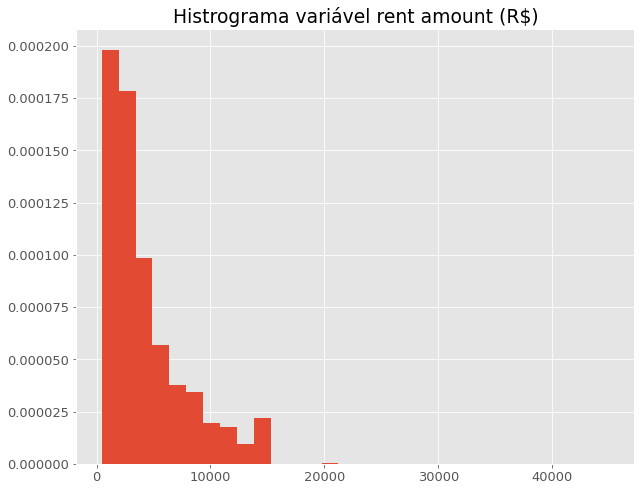

In [23]:
plt.figure(figsize=(10, 8))
plt.title('Histrograma variável rent amount (R$)')
plt.hist(df['rent amount (R$)'], density=True, bins=30) 

### Aplicando a transformação logarítma com o intuito melhorar a simetria dos dados, a transformação logaritima faz com que os dados fiquem proporcionais. Assim sua distribuição se aproxima da normal , melhorando o desempenho do modelo.

(array([0.00979838, 0.0173356 , 0.04597703, 0.07537218, 0.13190131,
        0.28339938, 0.36932367, 0.35048062, 0.36329389, 0.50273242,
        0.42359163, 0.50122497, 0.50273242, 0.41077836, 0.35726412,
        0.4258528 , 0.33992852, 0.28189194, 0.26380262, 0.20953465,
        0.21933303, 0.19295277, 0.22687025, 0.00075372, 0.00527605,
        0.00075372, 0.00075372, 0.00075372, 0.        , 0.00075372]),
 array([ 6.10924758,  6.26275326,  6.41625893,  6.5697646 ,  6.72327027,
         6.87677595,  7.03028162,  7.18378729,  7.33729297,  7.49079864,
         7.64430431,  7.79780998,  7.95131566,  8.10482133,  8.258327  ,
         8.41183268,  8.56533835,  8.71884402,  8.87234969,  9.02585537,
         9.17936104,  9.33286671,  9.48637239,  9.63987806,  9.79338373,
         9.9468894 , 10.10039508, 10.25390075, 10.40740642, 10.5609121 ,
        10.71441777]),
 <BarContainer object of 30 artists>)

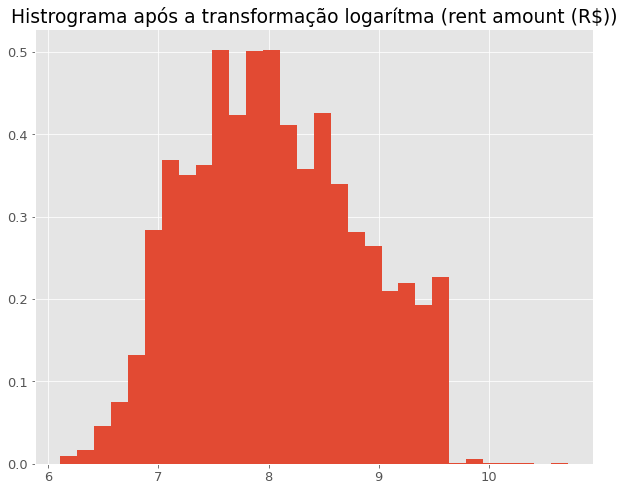

In [24]:
plt.figure(figsize=(10, 8))
plt.title('Histrograma após a transformação logarítma (rent amount (R$))')
plt.hist(np.log(df['rent amount (R$)']), density=True, bins=30)


In [25]:
df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,rent amount (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,3300
1,São Paulo,320,4,4,0,20,acept,not furnished,4960
4,São Paulo,25,1,1,0,1,not acept,not furnished,800
5,São Paulo,376,3,3,7,0,acept,not furnished,8000
6,Rio de Janeiro,72,2,1,0,7,acept,not furnished,8000
...,...,...,...,...,...,...,...,...,...
10686,São Paulo,150,3,3,2,8,not acept,furnished,13500
10688,São Paulo,285,4,4,4,17,acept,not furnished,15000
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,6000
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,12000


## 1) Foi divido em 70% para treino e 30% para teste - essa % foi escolhida dado que 30% do dataset corresponde a 2593 linhas , dados  suficientes para se ter uma estimativa precisa do risco. A separação entre treino e teste foi realizada antes do processamento dos dados para evitar data leakage.

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('rent amount (R$)', axis=1), df['rent amount (R$)'], test_size=0.3, random_state=42)

## Transformando valores 

In [27]:
transformer = make_column_transformer((StandardScaler(), ['area', 'rooms', 'bathroom', 'parking spaces', 'floor']),(OneHotEncoder(), ['city']),(OrdinalEncoder(categories= [["not acept", "acept"]]),['animal']),(OrdinalEncoder(categories= [["not furnished", "furnished"]]),['furniture']))

In [28]:
x_train_transf = transformer.fit_transform(x_train)
x_test_transf = transformer.transform(x_test)

In [29]:
df_transf = pd.DataFrame(x_train_transf, columns =['area','rooms','bathroom','parking spaces','floor','BH','RJ','SP', 'animal','furniture'] )

In [30]:
df_transf

,area,rooms,bathroom,parking spaces,floor,BH,RJ,SP,animal,furniture
0,0.156827,1.200247,1.162885,0.807887,0.873724,0.0,0.0,1.0,0.0,1.0
1,-0.771794,-1.321398,-0.929339,-0.423276,-0.216704,0.0,0.0,1.0,0.0,1.0
2,0.301924,0.359699,1.162885,1.423468,-0.943656,0.0,0.0,1.0,1.0,0.0
3,-0.604933,-0.480849,-0.231931,-1.038857,0.146772,0.0,0.0,1.0,1.0,0.0
4,0.447022,1.200247,0.465477,0.807887,1.055462,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
6045,-0.416306,0.359699,0.465477,0.807887,-0.034966,0.0,0.0,1.0,0.0,0.0
6046,-0.554149,-0.480849,-0.231931,-0.423276,0.146772,0.0,0.0,1.0,1.0,0.0
6047,1.245056,0.359699,1.860293,-1.038857,0.873724,0.0,0.0,1.0,0.0,0.0
6048,-0.351013,-0.480849,-0.231931,-0.423276,-0.398442,0.0,0.0,1.0,1.0,0.0


In [31]:
y_train_transf = np.log(y_train)
y_test_transf = np.log(y_test)

# Regressão Linear Simples (Mínimos Quadrados)

In [32]:
LR = LinearRegression()

In [33]:
LR.fit(x_train_transf,y_train_transf)

LinearRegression()

In [34]:
LR.coef_

array([ 0.19956439,  0.13696243,  0.19851499,  0.0904155 ,  0.09104006,
       -0.18404397,  0.04738412,  0.13665985,  0.01124942,  0.35458762])

In [35]:
coeff_df_lr = pd.DataFrame(LR.coef_,df_transf.columns,columns=['Coefficient'])

In [36]:
coeff_df_lr = coeff_df_lr.sort_values(by='Coefficient', ascending=True)

In [37]:
coeff_df_lr

,Coefficient
BH,-0.184044
animal,0.011249
RJ,0.047384
parking spaces,0.090416
floor,0.091040
SP,0.136660
rooms,0.136962
bathroom,0.198515
area,0.199564
furniture,0.354588


In [38]:
print('Intercepto:',LR.intercept_)

Intercepto: 7.885432958572059


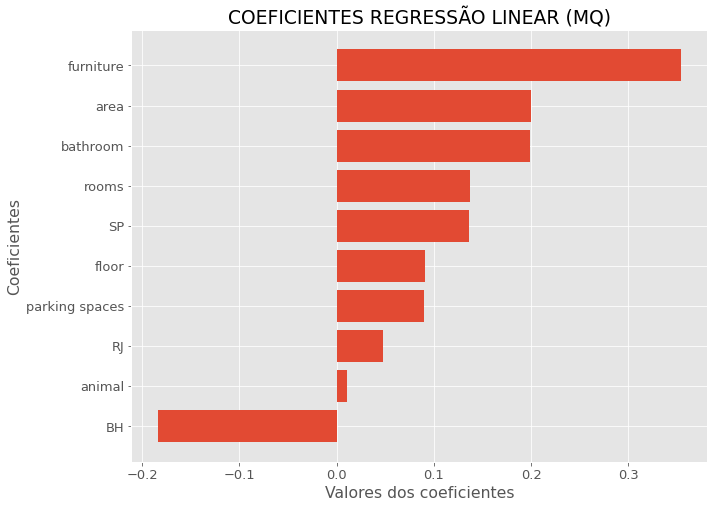

In [39]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Valores dos coeficientes")
plt.ylabel("Coeficientes")
plt.title('COEFICIENTES REGRESSÃO LINEAR (MQ)')
ax.barh(coeff_df_lr.index,coeff_df_lr['Coefficient'])
plt.show()

In [40]:
scores = cross_val_score(LR, x_train_transf, y_train_transf, cv=5,scoring='neg_mean_squared_error')

## Verificando MSE 

In [41]:
(-1*scores)

array([0.22518103, 0.23690785, 0.24768692, 0.25226343, 0.22591263])

# Regressão Lasso

In [42]:
lambdas_lasso = np.logspace(-3, 0, 30)

In [43]:
lasso = Lasso()
grid_lasso = GridSearchCV(estimator=lasso, param_grid=dict(alpha=lambdas_lasso), cv=5, scoring = 'neg_mean_squared_error')
grid_lasso.fit(x_train_transf,y_train_transf)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([0.001     , 0.00126896, 0.00161026, 0.00204336, 0.00259294,
       0.00329034, 0.00417532, 0.00529832, 0.00672336, 0.00853168,
       0.01082637, 0.01373824, 0.01743329, 0.02212216, 0.02807216,
       0.03562248, 0.04520354, 0.05736153, 0.07278954, 0.09236709,
       0.11721023, 0.14873521, 0.18873918, 0.23950266, 0.30391954,
       0.38566204, 0.48939009, 0.62101694, 0.78804628, 1.        ])},
             scoring='neg_mean_squared_error')

In [44]:
scores_lasso =(-grid_lasso.cv_results_['mean_test_score'])

(0.001, 1.0)

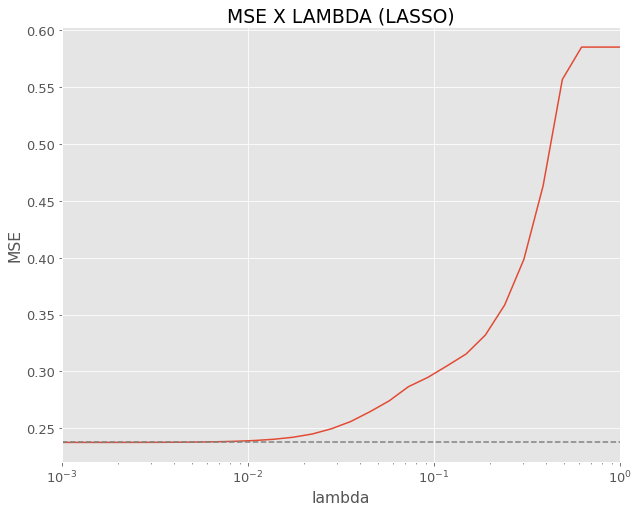

In [45]:
plt.figure().set_size_inches(10, 8)
plt.semilogx(lambdas_lasso, scores_lasso)
plt.ylabel('MSE')
plt.xlabel('lambda')
plt.title('MSE X LAMBDA (LASSO)')
plt.axhline(np.min(scores_lasso), linestyle='--', color='.5')
plt.xlim([lambdas_lasso[0], lambdas_lasso[-1]])

## Menor erro médio quadrado - lasso

In [46]:
np.min(scores_lasso)

0.23756280669768892

## 2) Lambda que minimiza o MSE - lasso

In [47]:
lambdas_lasso[np.argmin(scores_lasso)]

0.001

## Coefientes do modelo Lasso com lambda ajustado

In [48]:
reg_lasso = Lasso (alpha= lambdas_lasso[np.argmin(scores_lasso)])

In [49]:
reg_lasso.fit(x_train_transf,y_train_transf)

Lasso(alpha=0.001)

In [50]:
reg_lasso.coef_

array([ 0.19920427,  0.13550388,  0.1993808 ,  0.09016648,  0.0904426 ,
       -0.22496463, -0.        ,  0.0878403 ,  0.00597513,  0.34930453])

In [51]:
coeff_df_lasso = pd.DataFrame(reg_lasso.coef_,df_transf.columns,columns=['Coefficient'])

In [52]:
coeff_df_lasso =coeff_df_lasso.sort_values(by='Coefficient', ascending=True)

In [53]:
coeff_df_lasso

,Coefficient
BH,-0.224965
RJ,-0.000000
animal,0.005975
SP,0.087840
parking spaces,0.090166
floor,0.090443
rooms,0.135504
area,0.199204
bathroom,0.199381
furniture,0.349305


## Intercepto - lasso

In [54]:
print('Intercepto:',reg_lasso.intercept_)

Intercepto: 7.938147794127533


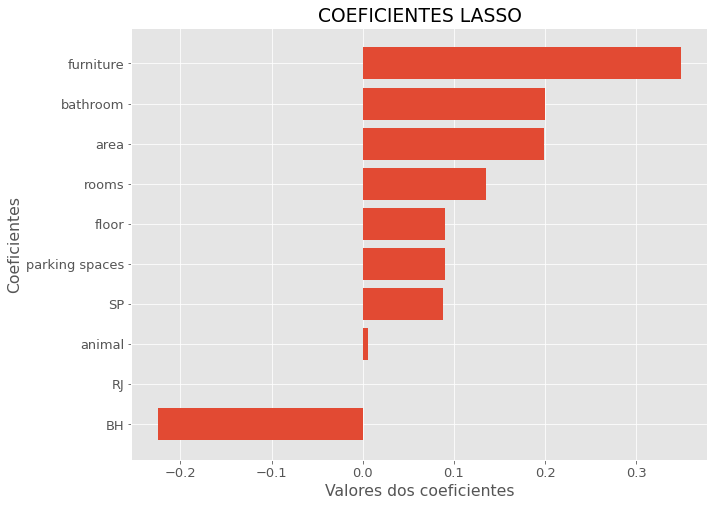

In [55]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Valores dos coeficientes")
plt.ylabel("Coeficientes")
plt.title('COEFICIENTES LASSO')
ax.barh(coeff_df_lasso.index,coeff_df_lasso['Coefficient'])
plt.show()

# Regressão Ridge

In [56]:
lambdas_ridge = np.logspace(-3, 8,30)

In [57]:
ridge = Ridge()
grid_ridge = GridSearchCV(estimator=ridge, param_grid=dict(alpha=lambdas_ridge), cv=5, scoring = 'neg_mean_squared_error')
grid_ridge.fit(x_train_transf,y_train_transf)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 2.39502662e-03, 5.73615251e-03, 1.37382380e-02,
       3.29034456e-02, 7.88046282e-02, 1.88739182e-01, 4.52035366e-01,
       1.08263673e+00, 2.59294380e+00, 6.21016942e+00, 1.48735211e+01,
       3.56224789e+01, 8.53167852e+01, 2.04335972e+02, 4.89390092e+02,
       1.17210230e+03, 2.80721620e+03, 6.72335754e+03, 1.61026203e+04,
       3.85662042e+04, 9.23670857e+04, 2.21221629e+05, 5.29831691e+05,
       1.26896100e+06, 3.03919538e+06, 7.27895384e+06, 1.74332882e+07,
       4.17531894e+07, 1.00000000e+08])},
             scoring='neg_mean_squared_error')

In [58]:
scores_ridge =-(grid_ridge.cv_results_['mean_test_score'])

(0.001, 100000000.0)

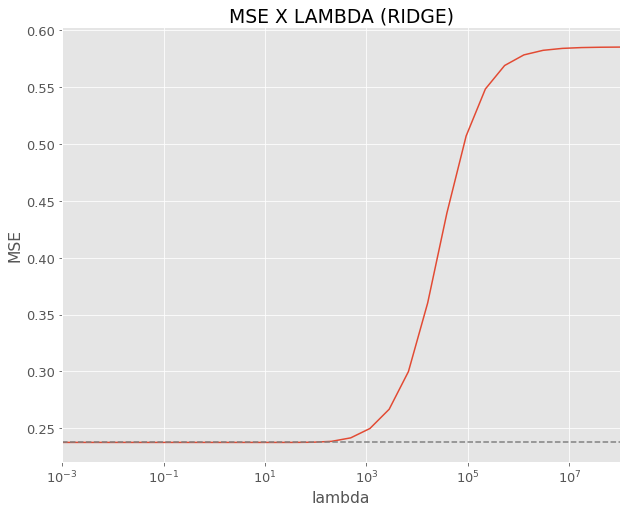

In [59]:
plt.figure().set_size_inches(10, 8)
plt.semilogx(lambdas_ridge, scores_ridge)
plt.ylabel('MSE')
plt.xlabel('lambda')
plt.title('MSE X LAMBDA (RIDGE)')
plt.axhline(np.min(scores_ridge), linestyle='--', color='.5')
plt.xlim([lambdas_ridge[0], lambdas_ridge[-1]])

## Menor erro médio quadrado - ridge

In [60]:
np.min(scores_ridge)

0.2375779610088689

## Lambda que minimiza o MSE - ridge

In [61]:
lambdas_ridge[np.argmin(scores_ridge)]

14.873521072935118

## Coefientes do modelo Ridge ajustado

In [62]:
reg_ridge = Ridge(alpha= lambdas_ridge[np.argmin(scores_ridge)])

In [63]:
reg_ridge.fit(x_train_transf,y_train_transf)

Ridge(alpha=14.873521072935118)

In [64]:
reg_ridge.coef_

array([ 0.19917452,  0.13631579,  0.19859808,  0.09068563,  0.0911197 ,
       -0.18182017,  0.04618553,  0.13563464,  0.01111452,  0.35008271])

In [65]:
coeff_df_ridge = pd.DataFrame(reg_ridge.coef_,df_transf.columns,columns=['Coefficient'])

In [66]:
coeff_df_ridge = coeff_df_ridge.sort_values(by='Coefficient', ascending=True)

In [67]:
coeff_df_ridge

,Coefficient
BH,-0.181820
animal,0.011115
RJ,0.046186
parking spaces,0.090686
floor,0.091120
SP,0.135635
rooms,0.136316
bathroom,0.198598
area,0.199175
furniture,0.350083


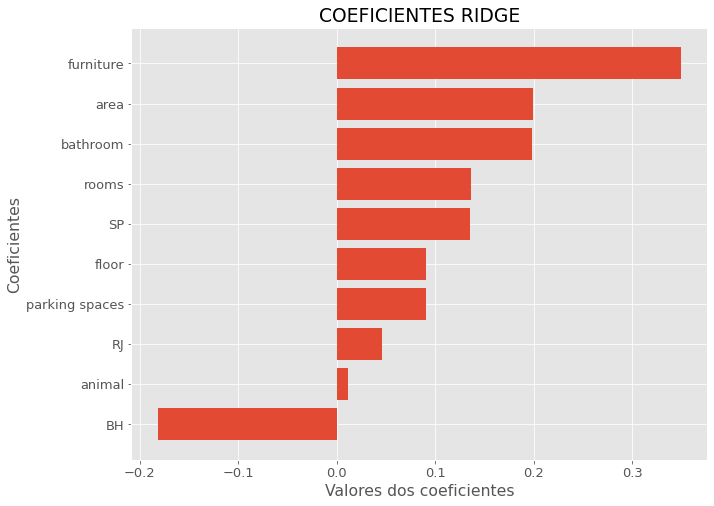

In [68]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Valores dos coeficientes")
plt.ylabel("Coeficientes")
plt.title('COEFICIENTES RIDGE')
ax.barh(coeff_df_ridge.index,coeff_df_ridge['Coefficient'])
plt.show()

## Intercepto - Ridge

In [69]:
print('Intercepto:',reg_lasso.intercept_)

Intercepto: 7.938147794127533


# Validação dos modelos
## Para escolher o melhor modelo , foi utilizado o Mean Absolute error evitando assim erros inflados (os dados voltaram para a mesma escala exp() ) 

In [70]:
y_pred_lr = LR.predict(x_test_transf)
y_pred_lasso = reg_lasso.predict(x_test_transf)
y_pred_ridge = reg_ridge.predict(x_test_transf)

## Intervalo de confiança

In [71]:
def std_error(loss_func , y_pred , y_test):
    ic = np.sqrt((1/len(y_test))*np.mean((abs(y_pred - y_test) - (loss_func(y_test, y_pred)))**2))
    return(2*ic)

In [72]:
std_error_lr = std_error(mean_absolute_error,np.exp(y_pred_lr),np.exp(y_test_transf))
std_error_lasso = std_error(mean_absolute_error,np.exp(y_pred_lasso),np.exp(y_test_transf))
std_error_ridge = std_error(mean_absolute_error,np.exp(y_pred_ridge),np.exp(y_test_transf))

In [73]:
mae_lr = mean_absolute_error(np.exp(y_test_transf), np.exp(y_pred_lr))
mae_lasso = mean_absolute_error(np.exp(y_test_transf), np.exp(y_pred_lasso))
mae_ridge = mean_absolute_error(np.exp(y_test_transf), np.exp(y_pred_ridge))

In [74]:
df_validacao = {"MODELOS": ["LR (MQ)", "LASSO", "RIDGE"] ,"MAE": [mae_lr, mae_lasso, mae_ridge], "IC_lower": [(mae_lr - std_error_lr),(mae_lasso-std_error_lasso),(mae_ridge-std_error_ridge)],"IC_power": [(mae_lr+std_error_lr),(mae_lasso+std_error_lasso),(mae_ridge+std_error_ridge)]}

In [75]:
df_validacao = pd.DataFrame(df_validacao)

In [76]:
df_validacao

,MODELOS,MAE,IC_lower,IC_power
0,LR (MQ),1766.816359,1664.951983,1868.680736
1,LASSO,1765.136095,1663.596101,1866.676090
2,RIDGE,1765.715901,1664.081617,1867.350186


In [77]:
df_validacao.MAE

0    1766.816359
1    1765.136095
2    1765.715901
Name: MAE, dtype: float64

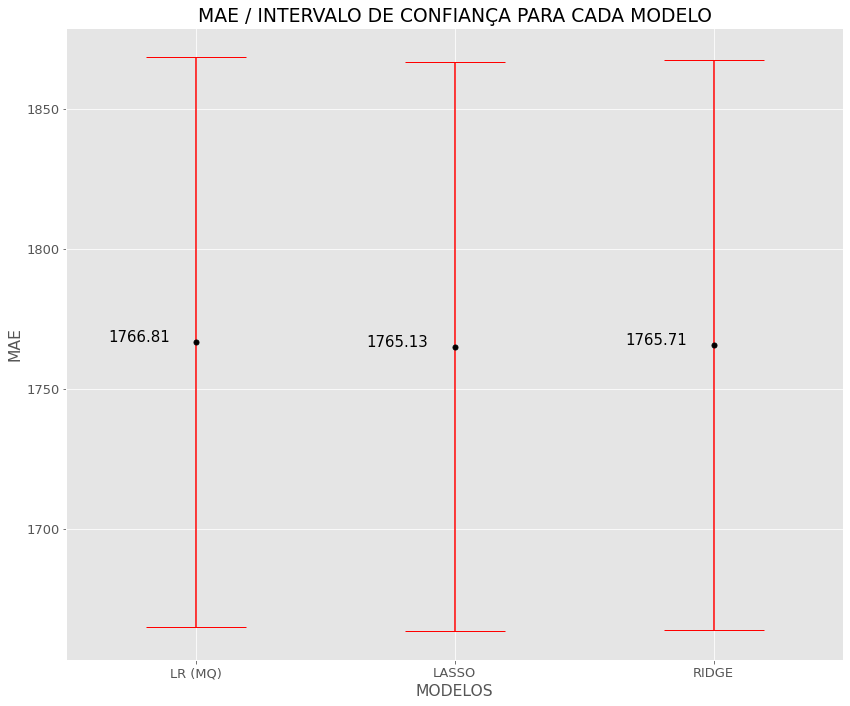

In [78]:
plt.figure().set_size_inches(12, 10)
x_ticks = df_validacao.MODELOS
x_1 = np.arange(1, 4)
y_1 = df_validacao.MAE
err_1 = [std_error_lr,std_error_lasso,std_error_ridge]
plt.errorbar(x=x_1, y=y_1, yerr=err_1, color="red", capsize=50,
             linestyle="None",
             marker="o", markersize=5, mfc="black", mec="black")
plt.title('MAE / INTERVALO DE CONFIANÇA PARA CADA MODELO')
plt.ylabel("MAE")
plt.xlabel("MODELOS")
plt.xticks(x_1, x_ticks)
plt.xlim([0.5, 3.5])
style = dict(size=15, color='black')
plt.text(0.66, 1766.816359, "1766.81", **style)
plt.text(1.66, 1765.136095, "1765.13", **style)
plt.text(2.66, 1765.715901, "1765.71", **style)
plt.tight_layout()
plt.show()

## 3) Melhor modelo encontrado foi o lasso para este caso, todos os modelos apresentaram resultados parecidos. Lasso aprenseta o menor ERRO MÉDIO ABSOLUTO.

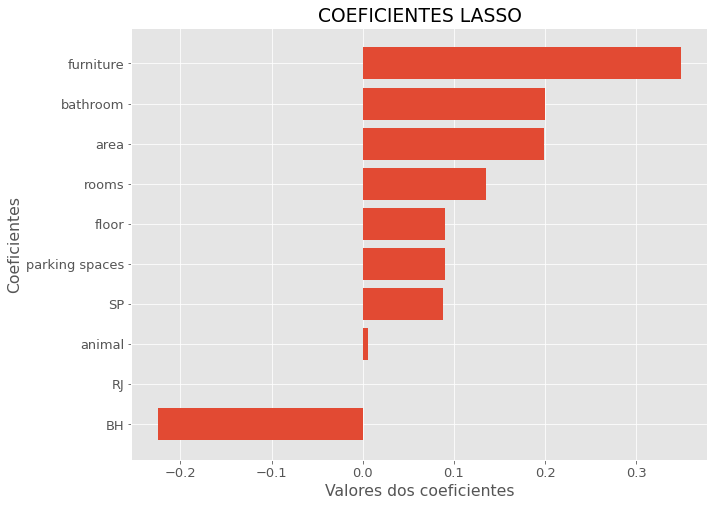

In [79]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Valores dos coeficientes")
plt.ylabel("Coeficientes")
plt.title('COEFICIENTES LASSO')
ax.barh(coeff_df_lasso.index,coeff_df_lasso['Coefficient'])
plt.show()

### 4) Atráves dos coeficientes, pode-se concluir que atritbutos como Furniture, Bathroom e area estão positivamente ligadas ao preço do aluguel. Imóveis em BH tendem a ter o preço menor que SP e RJ. Essas constatações fazem total sentido tendo em vista que Imóveis mobiliados , com maior area e mais banheiros são mais caros do que imóveis mais simples.


# Incluindo interações entre as features

In [80]:
poly = PolynomialFeatures()

In [81]:
x_all_train = poly.fit_transform(df_transf)
x_all_test = poly.transform(x_test_transf)

In [82]:
dfPoly = pd.DataFrame(x_all_train,columns=poly.get_feature_names(df_transf.columns))

In [83]:
dfPoly

,1,area,rooms,bathroom,parking spaces,floor,BH,RJ,SP,animal,...,RJ^2,RJ SP,RJ animal,RJ furniture,SP^2,SP animal,SP furniture,animal^2,animal furniture,furniture^2
0,1.0,0.156827,1.200247,1.162885,0.807887,0.873724,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,-0.771794,-1.321398,-0.929339,-0.423276,-0.216704,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.301924,0.359699,1.162885,1.423468,-0.943656,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
3,1.0,-0.604933,-0.480849,-0.231931,-1.038857,0.146772,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.447022,1.200247,0.465477,0.807887,1.055462,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,1.0,-0.416306,0.359699,0.465477,0.807887,-0.034966,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6046,1.0,-0.554149,-0.480849,-0.231931,-0.423276,0.146772,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
6047,1.0,1.245056,0.359699,1.860293,-1.038857,0.873724,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6048,1.0,-0.351013,-0.480849,-0.231931,-0.423276,-0.398442,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


# Regressão Linear (MQ)

In [84]:
LR_all = LinearRegression()
LR_all.fit(x_all_train,y_train_transf)

LinearRegression()

In [85]:
LR_all.coef_.size

66

In [86]:
LR_all.n_features_in_

66

In [87]:
coeff_df_lr_all = pd.DataFrame(LR_all.coef_,dfPoly.columns,columns=['Coefficient'])

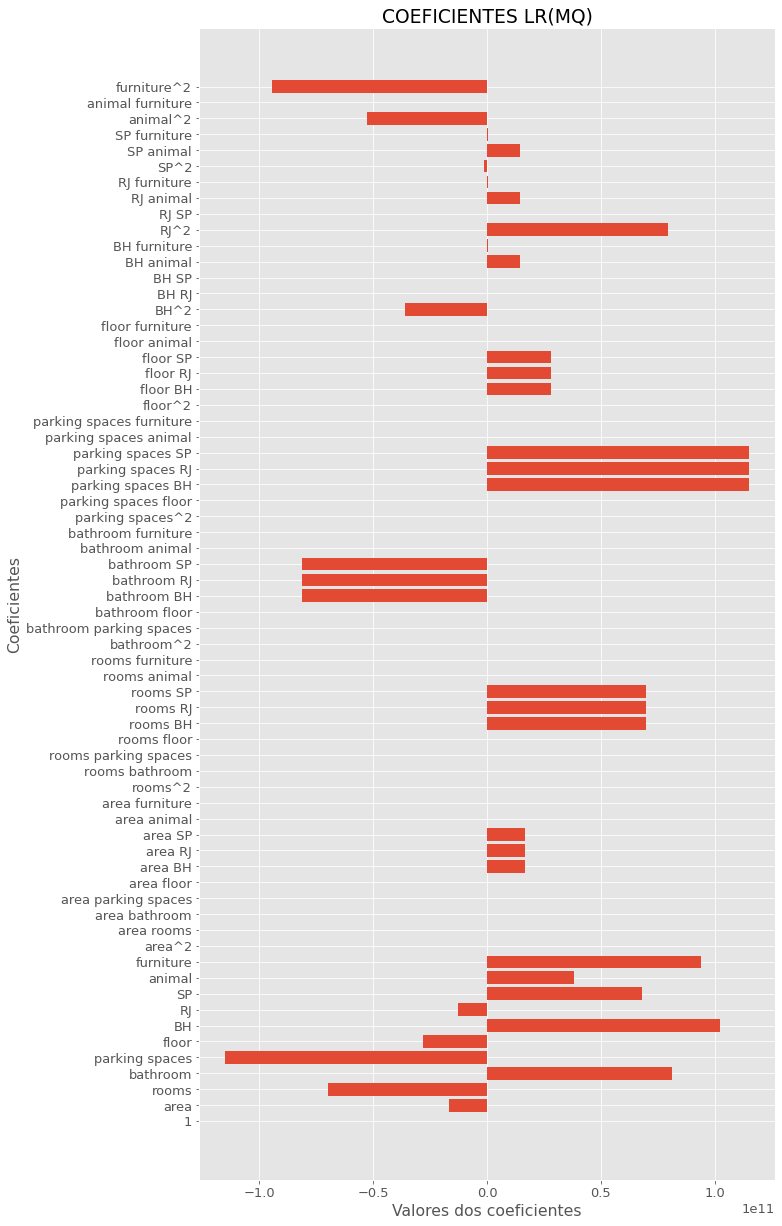

In [88]:
fig = plt.figure(figsize=(8, 16))
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Valores dos coeficientes")
plt.ylabel("Coeficientes")
plt.title('COEFICIENTES LR(MQ)')
ax.barh(coeff_df_lr_all.index,coeff_df_lr_all['Coefficient'])
plt.show()

# Regressão Lasso

In [89]:
lambdas_lasso_all = np.logspace(-3,0, 20)

In [90]:
lasso_all = Lasso()
grid_lasso_all = GridSearchCV(estimator=lasso_all, param_grid=dict(alpha=lambdas_lasso_all), cv=5, scoring = 'neg_mean_squared_error')
grid_lasso_all.fit(x_all_train,y_train_transf)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([0.001     , 0.00143845, 0.00206914, 0.00297635, 0.00428133,
       0.00615848, 0.00885867, 0.01274275, 0.01832981, 0.02636651,
       0.0379269 , 0.05455595, 0.078476  , 0.11288379, 0.16237767,
       0.23357215, 0.33598183, 0.48329302, 0.6951928 , 1.        ])},
             scoring='neg_mean_squared_error')

In [91]:
scores_lasso_all =(-grid_lasso_all.cv_results_['mean_test_score'])

(0.001, 1.0)

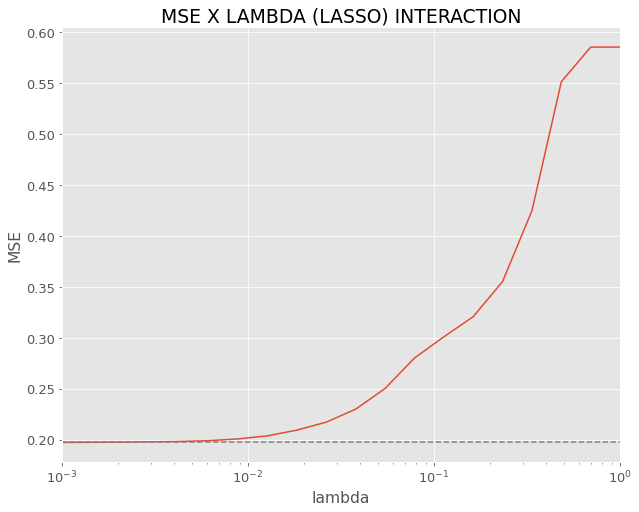

In [92]:
plt.figure().set_size_inches(10, 8)
plt.semilogx(lambdas_lasso_all,scores_lasso_all)
plt.ylabel('MSE')
plt.xlabel('lambda')
plt.title('MSE X LAMBDA (LASSO) INTERACTION')
plt.axhline(np.min(scores_lasso_all), linestyle='--', color='.5')
plt.xlim([lambdas_lasso_all[0], lambdas_lasso_all[-1]])

# MSE interaction

In [93]:
np.min(scores_lasso_all)

0.1971507392983659

## Lambda que minimiza o MSE - lasso (interaction)

In [94]:
lambdas_lasso_all[np.argmin(scores_lasso_all)]

0.001

In [95]:
reg_lasso_all = Lasso (alpha= lambdas_lasso_all[np.argmin(scores_lasso_all)])

In [96]:
reg_lasso_all.fit(x_all_train,y_train_transf)

Lasso(alpha=0.001)

In [97]:
coeff_df_lasso_all = pd.DataFrame(reg_lasso_all.coef_,dfPoly.columns,columns=['Coefficient'])

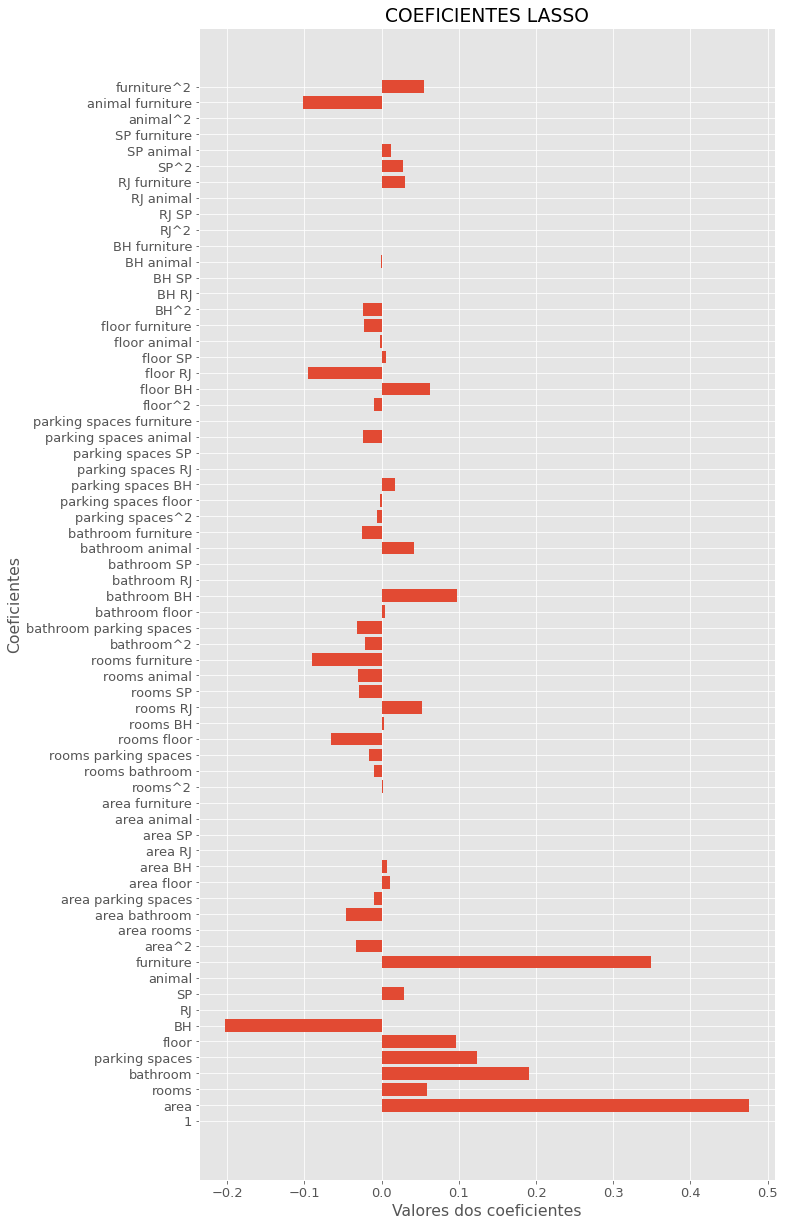

In [98]:
fig = plt.figure(figsize=(8, 16))
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Valores dos coeficientes")
plt.ylabel("Coeficientes")
plt.title('COEFICIENTES LASSO')
ax.barh(coeff_df_lasso_all.index,coeff_df_lasso_all['Coefficient'])
plt.show()

# Verificando os modelos (interação)

In [99]:
y_pred_lr_all = LR_all.predict(x_all_test)
y_pred_lasso_all = reg_lasso_all.predict(x_all_test)

In [100]:
std_error_lr_all = std_error(mean_absolute_error,np.exp(y_pred_lr_all),np.exp(y_test_transf))
std_error_lasso_all = std_error(mean_absolute_error,np.exp(y_pred_lasso_all),np.exp(y_test_transf))

In [101]:
mae_lr_all = mean_absolute_error(np.exp(y_test_transf), np.exp(y_pred_lr_all))
mae_lasso_all = mean_absolute_error(np.exp(y_test_transf), np.exp(y_pred_lasso_all))

In [102]:
df_validacao_all = {"MODELOS": ["LR (MQ)", "LASSO"] ,"MAE": [mae_lr_all, mae_lasso_all], "IC_lower": [(mae_lr_all - std_error_lr_all),(mae_lasso_all-std_error_lasso_all)],"IC_power": [(mae_lr_all+std_error_lr_all),(mae_lasso_all+std_error_lasso_all)]}

In [103]:
df_validacao_all = pd.DataFrame(df_validacao_all)

In [104]:
df_validacao_all

,MODELOS,MAE,IC_lower,IC_power
0,LR (MQ),1549.095379,1468.284872,1629.905885
1,LASSO,1545.282152,1464.793530,1625.770774


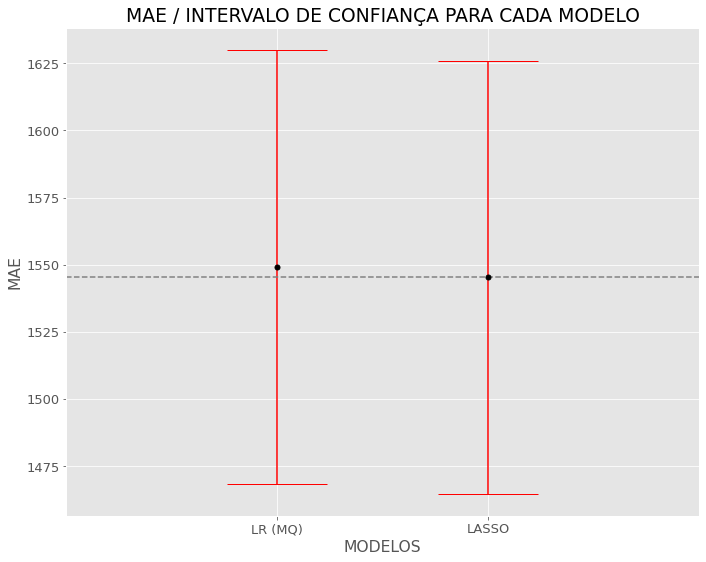

In [105]:
plt.figure().set_size_inches(10, 8)
x_ticks = df_validacao_all.MODELOS
x_1 = np.arange(1.5,3.5)
y_1 = df_validacao_all.MAE
err_1 = [std_error_lr_all,std_error_lasso_all]
plt.errorbar(x=x_1, y=y_1, yerr=err_1, color="red", capsize=50,
             linestyle="None",
             marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(df_validacao_all.MAE.min(), linestyle='--', color='.5')
plt.title('MAE / INTERVALO DE CONFIANÇA PARA CADA MODELO')
plt.ylabel("MAE")
plt.xlabel("MODELOS")
plt.xticks(x_1, x_ticks)
plt.xlim([0.5, 3.5])
plt.tight_layout()
plt.show()

## Foi observado uma melhora no desempenho, tendo em vista que com as interações os modelos se ajustaram melhor aos dados. A regressão via Lasso se saiu melhor. A penalização faz com que o modelo fique menos flexivel aumentando o viés e diminuindo a variância tento um risco estimado melhor. Diferente da regressão via mínimos quadrados onde não tem nenhum termo para regularização, fazendo com que a variância seja maior do que a regressão via lasso. Assim o risco estimado da regressão via mínimos quadrados seja um pouco maior.

In [106]:
erro_lr = np.exp(y_test_transf) - np.exp(y_pred_lr_all) 
erro_lasso = np.exp(y_test_transf) - np.exp(y_pred_lasso_all)
df_boxplot = {"ERRO_LR": erro_lr,"ERRO_LASSO": erro_lasso}
data_boxplot = pd.DataFrame(df_boxplot)

Text(0, 0.5, 'MODELOS')

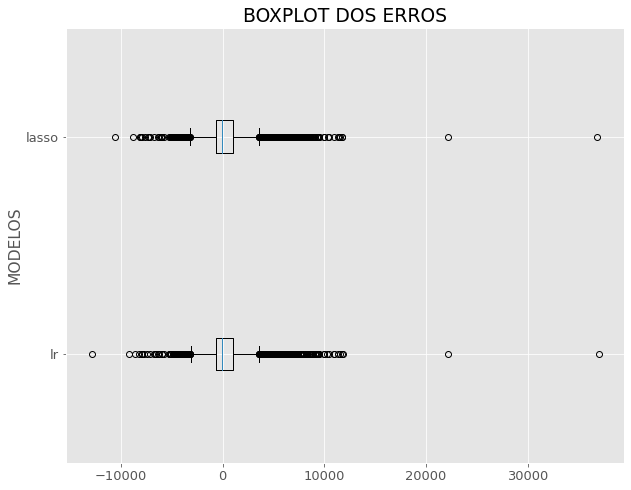

In [107]:
fig = plt.figure(1, figsize=(10,8))
ax = fig.add_subplot()
bp = ax.boxplot(data_boxplot,vert=False)
ax.set_yticklabels(['lr','lasso'])
plt.title('BOXPLOT DOS ERROS')
plt.ylabel("MODELOS")